# Titration Experiment

In [1]:
#############################
#   Experiment parameters   #
#############################
ROOT_DIR = '/analysis/gh-msun/'
PROJECT_SLUG = '2023_06_26_SRT_deconvolution_MS'
EXPERIMENT = 'primary_immune'
TITRATING_CELLTYPE = 'Blueprint-B'
TITRATING_CELLTYPE_ATLAS = 'immune_b' # cell type name in atlas different
BACKGROUND = 'wholeblood' # background: uniform / wholeblood 
N_REPLICATES = 2 # number of replicates for each mixture
SEED = 888 # need to change for different experiment
TOTAL_READS_TO_SAMPLE = 1000000

# make sure the orders of the two list match
CELLTYPES = ['Blueprint-CD4', 'Blueprint-CD8', 'Blueprint-B', 'Blueprint-NK', 'Blueprint-Mono', 'Blueprint-Neutro']
ABRIDGED_NAMES = ['CD4', 'CD8', 'B', 'NK', 'MONO', 'NEUTRO'] # for directory name

# TITRATION_LIST = [0.2, 0.15, 0.10, 0.08, 0.06, 0.04, 0.02, 0.01, 
#                   0.008, 0.006, 0.004, 0.002, 0.001, 0]
TITRATION_LIST=[0.2, 0.15]

# proportion of cells in real whole blood (sum to 1)
WHOLE_BLOOD_ABUNDANCE = {'Blueprint-B':0.06,
                         'Blueprint-Mono':0.09,
                         'Blueprint-Neutro':0.57,
                         'Blueprint-CD4':0.16,
                         'Blueprint-CD8':0.07,
                         'Blueprint-NK':0.05}
    

In [2]:
# Parameters
ROOT_DIR = "/analysis/gh-msun/"
PROJECT_SLUG = "2023_06_26_SRT_deconvolution_MS"
EXPERIMENT = "primary_immune"
TITRATING_CELLTYPE = "Blueprint-CD8"
TITRATING_CELLTYPE_ATLAS = "immune_t"
BACKGROUND = "wholeblood"
N_REPLICATES = 20
SEED = 452891
TOTAL_READS_TO_SAMPLE = 1000000
CELLTYPES = ["Blueprint-CD4", "Blueprint-CD8", "Blueprint-B", "Blueprint-NK", "Blueprint-Mono", "Blueprint-Neutro"]
ABRIDGED_NAMES = ["CD4", "CD8", "B", "NK", "MONO", "NEUTRO"]
TITRATION_LIST = [0.2, 0.15, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.008, 0.006, 0.004, 0.002, 0.001, 0]
WHOLE_BLOOD_ABUNDANCE = {"Blueprint-B": 0.06, "Blueprint-Mono": 0.09, "Blueprint-Neutro": 0.57, "Blueprint-CD4": 0.16, "Blueprint-CD8": 0.07, "Blueprint-NK": 0.05}


In [3]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import functools
import os
import regex as re
import random
import importlib
import sys

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import IntegerType, LongType, ArrayType, StringType, DoubleType
from pyspark.sql.functions import udf, explode, broadcast, count, lit, length, col
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType

# UPDATE HOME!
os.environ["SPARK_HOME"] = "/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark"
# THIS needs to be set-up before running the notebook
os.environ["SPARK_LOCAL_DIRS"] = "/temp"
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

spark_conf = SparkConf()
spark_conf.set("spark.ui.showConsoleProgress", "True")
spark_conf.set("spark.executor.instances", "2")
spark_conf.set("spark.executor.cores", "2")
spark_conf.set("spark.executor.memory", "16g")
spark_conf.set("spark.driver.memory", "64g")
spark_conf.set("spark.driver.maxResultSize", "32g")
spark_conf.set("spark.parquet.filterPushdown", "true")
spark_conf.set("spark.local.dir", "/temp")
spark_conf.getAll()

sc = SparkContext(conf=spark_conf)
sc.setLogLevel("ERROR")
spark = SparkSession(sc)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_context('talk')

/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [4]:
#---Local paths---#
PROJECT_DIR = ROOT_DIR + f'projects/{PROJECT_SLUG}/'

#---Load all custom scripts---#
SCRIPT_DIR = PROJECT_DIR + 'scripts/'
sys.path.append(SCRIPT_DIR)

import create_mixture as cm
import score_matrix as sm
import deconvolution as dcnv
import helper as hlpr

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
importlib.reload(cm)
importlib.reload(sm)
importlib.reload(dcnv)
importlib.reload(hlpr)

<module 'helper' from '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/scripts/helper.py'>

In [6]:
#################################
#   Set titration proportions   #
#################################

# Reorder such that the titrating cell type comes first
CELLTYPES_unordered = CELLTYPES.copy()
CELLTYPES = hlpr.titration_reordering(list_of_cell_types=CELLTYPES, 
                                      titrating_cell_type=TITRATING_CELLTYPE)

# Reorder abridged name
ABRIDGED_NAMES = hlpr.reorder_abridged_name(unordered_celltypes=CELLTYPES_unordered,
                                            ordered_celltypes=CELLTYPES,
                                            unordered_abridged_names=ABRIDGED_NAMES)
    
# set titration proportions
if BACKGROUND == 'uniform':
    PROPORTIONS = hlpr.generate_uniform_background_proportions(titration_list=TITRATION_LIST, 
                                                               cell_types=CELLTYPES)

if BACKGROUND == 'wholeblood':
    PROPORTIONS = hlpr.generate_custom_background_proportions(titration_list=TITRATION_LIST, 
                                                              custom_proportion=WHOLE_BLOOD_ABUNDANCE, 
                                                              list_of_celltypes=CELLTYPES, 
                                                              titrating_celltype=TITRATING_CELLTYPE)

PROPORTIONS[0]    

[0.2,
 0.13763440860215054,
 0.05161290322580645,
 0.043010752688172046,
 0.07741935483870968,
 0.4903225806451612]

## Create mixture

In [7]:
############################
#   Parameters and paths   # 
############################
EXPERIMENT_DIR = PROJECT_DIR + f'output/experiment/{EXPERIMENT}/'
EXPERIMENT_NAME = f'{TITRATING_CELLTYPE}-{BACKGROUND}/'
PARQUET_PATH = PROJECT_DIR + 'output/mixture_source/'
EXPERIMENT_CELLTYPE_DIR = EXPERIMENT_DIR + f'{EXPERIMENT_NAME}/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR + 'mixture/'


In [8]:
%%time
# load parquet files for each celltype & count rows
parquet_df, total_reads_per_celltype = cm.load_parquet_dataframe(parquet_path=PARQUET_PATH,
                                                                  cell_types=CELLTYPES,
                                                                  spark=spark,
                                                                  verbose=True)

# mix cell types for each proportion set
cm.mix_celltypes_multiple_proportions(parquet_df=parquet_df,
                                       total_reads_per_celltype=total_reads_per_celltype,
                                    #    n=len(TITRATION_LIST), 
                                       n=N_REPLICATES,
                                       cell_types=CELLTYPES, 
                                       cell_type_abridged_name=ABRIDGED_NAMES, 
                                       total_reads_to_sample=TOTAL_READS_TO_SAMPLE, 
                                       list_of_proportions=PROPORTIONS, 
                                       seed=SEED, 
                                       result_path=RESULT_PATH, 
                                       spark=spark,
                                       verbose=False, 
                                       save=True)

>>> Load parquet files and count rows... <<<
----------> Loading cell type: Blueprint-CD8


----------> Loading cell type: Blueprint-CD4


----------> Loading cell type: Blueprint-B


----------> Loading cell type: Blueprint-NK


----------> Loading cell type: Blueprint-Mono


----------> Loading cell type: Blueprint-Neutro


>>> Complete. <<< 

>>> Start mixing... <<<
--> PROPORTION: [0.2, 0.13763440860215054, 0.05161290322580645, 0.043010752688172046, 0.07741935483870968, 0.4903225806451612]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.15, 0.14623655913978492, 0.05483870967741935, 0.0456989247311828, 0.08225806451612903, 0.5209677419354838]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.1, 0.15483870967741933, 0.05806451612903226, 0.04838709677419355, 0.08709677419354839, 0.5516129032258064]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.08, 0.1582795698924731, 0.05935483870967742, 0.049462365591397855, 0.08903225806451613, 0.5638709677419355]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.06, 0.16172043010752685, 0.060645161290322575, 0.05053763440860215, 0.09096774193548386, 0.5761290322580644]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.04, 0.16516129032258062, 0.061935483870967735, 0.05161290322580645, 0.0929032258064516, 0.5883870967741934]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.02, 0.1686021505376344, 0.0632258064516129, 0.05268817204301075, 0.09483870967741935, 0.6006451612903225]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.01, 0.1703225806451613, 0.06387096774193549, 0.0532258064516129, 0.09580645161290323, 0.606774193548387]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.008, 0.17066666666666666, 0.064, 0.05333333333333334, 0.096, 0.6079999999999999]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.006, 0.17101075268817204, 0.06412903225806452, 0.053440860215053766, 0.09619354838709678, 0.6092258064516128]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.004, 0.1713548387096774, 0.06425806451612903, 0.053548387096774196, 0.09638709677419355, 0.6104516129032257]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.002, 0.17169892473118278, 0.06438709677419355, 0.053655913978494625, 0.09658064516129032, 0.6116774193548387]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.001, 0.17187096774193547, 0.0644516129032258, 0.05370967741935484, 0.0966774193548387, 0.6122903225806451]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0, 0.17204301075268816, 0.06451612903225806, 0.053763440860215055, 0.0967741935483871, 0.6129032258064515]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


>>> Complete. <<< 

CPU times: user 1.39 s, sys: 377 ms, total: 1.77 s
Wall time: 24min 22s


## Compute score matrix

In [9]:
############################
#   Parameters and paths   # 
############################

FILTER_CG_COUNT = 3
FILTER_CG_COUNT_REGION = 1

REGIONS = 'deconvolution_v2.v23_conv.with_cpg_index'
REGION_BED_COLS = [
    'region_chr', 'region_start', 'region_end', 
    'region_cpg_index_min', 'region_cpg_index_max', 'region_id'
]

# Regions
REGION_PATH = (
    PROJECT_DIR + '/stage/panel_data/{regions}.bed'
).format(regions=REGIONS)

# CpG map; genomic coordinate to CpG index;
CPG_MAP_PATH = PROJECT_DIR + '/stage/cpg_loci/cpg_loci_hg19.combined_annot.tsv.gz'

#--- Where to store results
PATH_TO_MIXTURE_DIR = EXPERIMENT_CELLTYPE_DIR + 'mixture/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR


In [10]:
cpg_map = pd.read_csv(CPG_MAP_PATH, usecols=['chr', 'start', 'end', 'cpg_index', 'cpg_index_hg38'], sep='\t')

In [11]:
%%time
ridxs = ~cpg_map['cpg_index_hg38'].isna()
hg19_hg38_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index'], cpg_map[ridxs]['cpg_index_hg38'].astype(int)))
hg38_hg19_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index_hg38'].astype(int), cpg_map[ridxs]['cpg_index']))

CPU times: user 14.6 s, sys: 5.15 s, total: 19.8 s
Wall time: 19.7 s


In [12]:
region_df = pd.read_csv(REGION_PATH, sep='\t', usecols=range(0, 6), names=REGION_BED_COLS)

region_df['region_cpg_index_max'] -= 1
region_df.sort_values('region_cpg_index_min', inplace=True)
region_df['region_cpg_index_min_hg38'] = region_df['region_cpg_index_min'].map(hg19_hg38_map)
region_df['region_cpg_index_max_hg38'] = region_df['region_cpg_index_max'].map(hg19_hg38_map)

region_df.shape[0], region_df['region_id'].nunique()

(1658, 1658)

In [13]:
ridxs = ~region_df['region_cpg_index_min_hg38'].isna()
ridxs &= ~region_df['region_cpg_index_max_hg38'].isna()
region_df = region_df[ridxs].copy()
region_df.shape[0], region_df['region_id'].nunique()

(1658, 1658)

In [14]:
cg_count_hg19 = region_df['region_cpg_index_max']-region_df['region_cpg_index_min'] + 1
cg_count_hg38 = region_df['region_cpg_index_max_hg38']-region_df['region_cpg_index_min_hg38'] + 1
ridxs = (cg_count_hg19==cg_count_hg38)
ridxs &= (cg_count_hg19>=FILTER_CG_COUNT_REGION)
region_df = region_df[ridxs].copy()
region_df.shape[0], region_df['region_id'].nunique()

(1657, 1657)

In [15]:
region_df['region_cpg_index_min_hg38'] = region_df['region_cpg_index_min_hg38'].astype(int)
region_df['region_cpg_index_max_hg38'] = region_df['region_cpg_index_max_hg38'].astype(int)

In [16]:
### Restrict to immune regions
#-------------- CHANGE HERE FOR DIFFERENT REGION SUBSET ----------------------
# BLUEPRINT immune regions
ATLAS_PATH = PROJECT_DIR + f'/output/reference/deconv_inhouse_v2.atlas.tsv.gz'
atlas = pd.read_csv(ATLAS_PATH, sep='\t')
subset_region_set = set(atlas.region_id)
#-----------------------------------------------------------------------------

# filter regions down to regions of interest
region_df = region_df[region_df['region_id'].isin(subset_region_set)]
region_df.head()

,region_chr,region_start,region_end,region_cpg_index_min,region_cpg_index_max,region_id,region_cpg_index_min_hg38,region_cpg_index_max_hg38
0,chr1,1114771,1114971,20117,20129,Immune_Broad_B-chr1:1114772-1114971,21119,21131
1,chr1,1157450,1157720,21684,21703,Immune_Broad_NK-chr1:1157451-1157720,22686,22705
2,chr1,1157879,1158277,21710,21726,Immune_Broad_NK-chr1:1157880-1158277,22712,22728
14,chr1,6341182,6341377,140667,140681,Immune_Broad_Eosi-chr1:6341183-6341377,142368,142382
19,chr1,9147788,9147871,188605,188608,Immune_Broad_Neutro-chr1:9147789-9147871,190307,190310


In [17]:
%%time

PAT_COLS = [
    'molecule_id', 'chr', 'number_molecules',
    'cpg_index_min', 'cpg_index_max', 'pat_string', 'region_id', 'region_cpg_index_min', 'region_cpg_index_max'
]

QUANTILES = [0.1, 0.25, 0.75, 0.9]
KMERS = [1, 3, 4]
RATES_LEQ = [0.25]
RATES_GEQ = [0.75]

RETURN_SCHEMA = StructType()\
    .add('region_id', 'string')\
    .add('number_molecules', 'integer')\
    .add('meth_k1', 'integer')\
    .add('unmeth_k1', 'integer')\
    .add('total_k1', 'integer')\
    .add('meth_k3', 'integer')\
    .add('unmeth_k3', 'integer')\
    .add('total_k3', 'integer')\
    .add('meth_k4', 'integer')\
    .add('unmeth_k4', 'integer')\
    .add('total_k4', 'integer')\
    .add('frac_alpha_leq_25pct', 'float')\
    .add('frac_alpha_geq_75pct', 'float')

compute_frag_scores_udf = sm.compute_frag_scores(cpg_number_cutoff=FILTER_CG_COUNT, schema=RETURN_SCHEMA, kmers=KMERS, rates_leq=RATES_LEQ, rates_geq=RATES_GEQ)


# compute methyl score for are parquet files
sm.score_matrix_from_mixture_directory(path_to_mixture_dir = PATH_TO_MIXTURE_DIR, 
                                       result_path = RESULT_PATH, 
                                       pat_cols = PAT_COLS, 
                                       region_df = region_df, 
                                       batch_size = 20, 
                                       schema = RETURN_SCHEMA, 
                                       spark=spark,
                                       compute_frag_scores_udf=compute_frag_scores_udf,
                                       save=True, 
                                       verbose=False)

>>> Start computing score matrices <<< 

--> E2CD8_E1376CD4_E0516B_E043NK_E0774MONO_E4903NEUTRO
--------> Computing score matrix for mix0_seed807624


--------> Computing score matrix for mix1_seed468585


--------> Computing score matrix for mix2_seed529349


--------> Computing score matrix for mix3_seed85677


--------> Computing score matrix for mix4_seed833062


--------> Computing score matrix for mix5_seed474228


--------> Computing score matrix for mix6_seed205358


--------> Computing score matrix for mix7_seed858531


--------> Computing score matrix for mix8_seed709079


--------> Computing score matrix for mix9_seed86752


--------> Computing score matrix for mix10_seed360004


--------> Computing score matrix for mix11_seed311545


--------> Computing score matrix for mix12_seed860236


--------> Computing score matrix for mix13_seed163145


--------> Computing score matrix for mix14_seed30506


--------> Computing score matrix for mix15_seed48414


--------> Computing score matrix for mix16_seed841073


--------> Computing score matrix for mix17_seed323652


--------> Computing score matrix for mix18_seed219258


--------> Computing score matrix for mix19_seed136928




--> E15CD8_E1462CD4_E0548B_E0457NK_E0823MONO_E521NEUTRO
--------> Computing score matrix for mix0_seed433927


--------> Computing score matrix for mix1_seed103593


--------> Computing score matrix for mix2_seed710610


--------> Computing score matrix for mix3_seed432421


--------> Computing score matrix for mix4_seed657275


--------> Computing score matrix for mix5_seed489087


--------> Computing score matrix for mix6_seed422113


--------> Computing score matrix for mix7_seed982373


--------> Computing score matrix for mix8_seed567657


--------> Computing score matrix for mix9_seed70154


--------> Computing score matrix for mix10_seed71015


--------> Computing score matrix for mix11_seed340835


--------> Computing score matrix for mix12_seed38994


--------> Computing score matrix for mix13_seed322289


--------> Computing score matrix for mix14_seed852044


--------> Computing score matrix for mix15_seed900289


--------> Computing score matrix for mix16_seed848045


--------> Computing score matrix for mix17_seed716226


--------> Computing score matrix for mix18_seed171262


--------> Computing score matrix for mix19_seed385539




--> E1CD8_E1548CD4_E0581B_E0484NK_E0871MONO_E5516NEUTRO
--------> Computing score matrix for mix0_seed526983


--------> Computing score matrix for mix1_seed700547


--------> Computing score matrix for mix2_seed270544


--------> Computing score matrix for mix3_seed320525


--------> Computing score matrix for mix4_seed545492


--------> Computing score matrix for mix5_seed858881


--------> Computing score matrix for mix6_seed850056


--------> Computing score matrix for mix7_seed653076


--------> Computing score matrix for mix8_seed59388


--------> Computing score matrix for mix9_seed207169


--------> Computing score matrix for mix10_seed772729


--------> Computing score matrix for mix11_seed833877


--------> Computing score matrix for mix12_seed139264


--------> Computing score matrix for mix13_seed760876


--------> Computing score matrix for mix14_seed985485


--------> Computing score matrix for mix15_seed418421


--------> Computing score matrix for mix16_seed951378


--------> Computing score matrix for mix17_seed524387


--------> Computing score matrix for mix18_seed459586


--------> Computing score matrix for mix19_seed655679




--> E08CD8_E1583CD4_E0594B_E0495NK_E089MONO_E5639NEUTRO
--------> Computing score matrix for mix0_seed174361


--------> Computing score matrix for mix1_seed183384


--------> Computing score matrix for mix2_seed880752


--------> Computing score matrix for mix3_seed122581


--------> Computing score matrix for mix4_seed119604


--------> Computing score matrix for mix5_seed496753


--------> Computing score matrix for mix6_seed115523


--------> Computing score matrix for mix7_seed867497


--------> Computing score matrix for mix8_seed231656


--------> Computing score matrix for mix9_seed622365


--------> Computing score matrix for mix10_seed346385


--------> Computing score matrix for mix11_seed484455


--------> Computing score matrix for mix12_seed911498


--------> Computing score matrix for mix13_seed723283


--------> Computing score matrix for mix14_seed325608


--------> Computing score matrix for mix15_seed127121


--------> Computing score matrix for mix16_seed668278


--------> Computing score matrix for mix17_seed85224


--------> Computing score matrix for mix18_seed827710


--------> Computing score matrix for mix19_seed934055




--> E06CD8_E1617CD4_E0606B_E0505NK_E091MONO_E5761NEUTRO
--------> Computing score matrix for mix0_seed4453


--------> Computing score matrix for mix1_seed857135


--------> Computing score matrix for mix2_seed279914


--------> Computing score matrix for mix3_seed792879


--------> Computing score matrix for mix4_seed451105


--------> Computing score matrix for mix5_seed630157


--------> Computing score matrix for mix6_seed574543


--------> Computing score matrix for mix7_seed69699


--------> Computing score matrix for mix8_seed570484


--------> Computing score matrix for mix9_seed81972


--------> Computing score matrix for mix10_seed871523


--------> Computing score matrix for mix11_seed55921


--------> Computing score matrix for mix12_seed645313


--------> Computing score matrix for mix13_seed522030


--------> Computing score matrix for mix14_seed270474


--------> Computing score matrix for mix15_seed980329


--------> Computing score matrix for mix16_seed593971


--------> Computing score matrix for mix17_seed105733


--------> Computing score matrix for mix18_seed200762


--------> Computing score matrix for mix19_seed73407




--> E04CD8_E1652CD4_E0619B_E0516NK_E0929MONO_E5884NEUTRO
--------> Computing score matrix for mix0_seed584293


--------> Computing score matrix for mix1_seed923419


--------> Computing score matrix for mix2_seed493429


--------> Computing score matrix for mix3_seed72631


--------> Computing score matrix for mix4_seed791128


--------> Computing score matrix for mix5_seed347720


--------> Computing score matrix for mix6_seed150297


--------> Computing score matrix for mix7_seed366963


--------> Computing score matrix for mix8_seed716374


--------> Computing score matrix for mix9_seed264090


--------> Computing score matrix for mix10_seed825122


--------> Computing score matrix for mix11_seed714460


--------> Computing score matrix for mix12_seed476036


--------> Computing score matrix for mix13_seed988867


--------> Computing score matrix for mix14_seed691296


--------> Computing score matrix for mix15_seed275917


--------> Computing score matrix for mix16_seed970205


--------> Computing score matrix for mix17_seed590620


--------> Computing score matrix for mix18_seed438487


--------> Computing score matrix for mix19_seed660786




--> E02CD8_E1686CD4_E0632B_E0527NK_E0948MONO_E6006NEUTRO
--------> Computing score matrix for mix0_seed173690


--------> Computing score matrix for mix1_seed144746


--------> Computing score matrix for mix2_seed635108


--------> Computing score matrix for mix3_seed46139


--------> Computing score matrix for mix4_seed898861


--------> Computing score matrix for mix5_seed658578


--------> Computing score matrix for mix6_seed793773


--------> Computing score matrix for mix7_seed387989


--------> Computing score matrix for mix8_seed668362


--------> Computing score matrix for mix9_seed898122


--------> Computing score matrix for mix10_seed245598


--------> Computing score matrix for mix11_seed233934


--------> Computing score matrix for mix12_seed160763


--------> Computing score matrix for mix13_seed259421


--------> Computing score matrix for mix14_seed629624


--------> Computing score matrix for mix15_seed635544


--------> Computing score matrix for mix16_seed291557


--------> Computing score matrix for mix17_seed344639


--------> Computing score matrix for mix18_seed905569


--------> Computing score matrix for mix19_seed694781




--> E01CD8_E1703CD4_E0639B_E0532NK_E0958MONO_E6068NEUTRO
--------> Computing score matrix for mix0_seed435156


--------> Computing score matrix for mix1_seed710239


--------> Computing score matrix for mix2_seed137738


--------> Computing score matrix for mix3_seed962846


--------> Computing score matrix for mix4_seed792384


--------> Computing score matrix for mix5_seed342127


--------> Computing score matrix for mix6_seed474583


--------> Computing score matrix for mix7_seed320679


--------> Computing score matrix for mix8_seed343284


--------> Computing score matrix for mix9_seed572922


--------> Computing score matrix for mix10_seed860400


--------> Computing score matrix for mix11_seed718921


--------> Computing score matrix for mix12_seed519660


--------> Computing score matrix for mix13_seed788645


--------> Computing score matrix for mix14_seed408995


--------> Computing score matrix for mix15_seed960058


--------> Computing score matrix for mix16_seed692624


--------> Computing score matrix for mix17_seed159700


--------> Computing score matrix for mix18_seed110302


--------> Computing score matrix for mix19_seed133051




--> E008CD8_E1707CD4_E064B_E0533NK_E096MONO_E608NEUTRO
--------> Computing score matrix for mix0_seed418951


--------> Computing score matrix for mix1_seed187275


--------> Computing score matrix for mix2_seed474061


--------> Computing score matrix for mix3_seed894284


--------> Computing score matrix for mix4_seed719371


--------> Computing score matrix for mix5_seed114980


--------> Computing score matrix for mix6_seed853388


--------> Computing score matrix for mix7_seed911622


--------> Computing score matrix for mix8_seed196163


--------> Computing score matrix for mix9_seed651976


--------> Computing score matrix for mix10_seed796391


--------> Computing score matrix for mix11_seed671533


--------> Computing score matrix for mix12_seed553961


--------> Computing score matrix for mix13_seed778269


--------> Computing score matrix for mix14_seed130253


--------> Computing score matrix for mix15_seed40062


--------> Computing score matrix for mix16_seed883912


--------> Computing score matrix for mix17_seed194413


--------> Computing score matrix for mix18_seed186350


--------> Computing score matrix for mix19_seed438203




--> E006CD8_E171CD4_E0641B_E0534NK_E0962MONO_E6092NEUTRO
--------> Computing score matrix for mix0_seed407249


--------> Computing score matrix for mix1_seed564743


--------> Computing score matrix for mix2_seed899169


--------> Computing score matrix for mix3_seed309348


--------> Computing score matrix for mix4_seed273010


--------> Computing score matrix for mix5_seed617478


--------> Computing score matrix for mix6_seed218062


--------> Computing score matrix for mix7_seed981250


--------> Computing score matrix for mix8_seed685440


--------> Computing score matrix for mix9_seed644462


--------> Computing score matrix for mix10_seed961073


--------> Computing score matrix for mix11_seed918989


--------> Computing score matrix for mix12_seed575166


--------> Computing score matrix for mix13_seed436461


--------> Computing score matrix for mix14_seed689276


--------> Computing score matrix for mix15_seed960959


--------> Computing score matrix for mix16_seed354294


--------> Computing score matrix for mix17_seed798861


--------> Computing score matrix for mix18_seed192832


--------> Computing score matrix for mix19_seed639532




--> E004CD8_E1714CD4_E0643B_E0535NK_E0964MONO_E6105NEUTRO
--------> Computing score matrix for mix0_seed834555


--------> Computing score matrix for mix1_seed19102


--------> Computing score matrix for mix2_seed911560


--------> Computing score matrix for mix3_seed59861


--------> Computing score matrix for mix4_seed819251


--------> Computing score matrix for mix5_seed412338


--------> Computing score matrix for mix6_seed818362


--------> Computing score matrix for mix7_seed408669


--------> Computing score matrix for mix8_seed276257


--------> Computing score matrix for mix9_seed392877


--------> Computing score matrix for mix10_seed558255


--------> Computing score matrix for mix11_seed806633


--------> Computing score matrix for mix12_seed953068


--------> Computing score matrix for mix13_seed31054


--------> Computing score matrix for mix14_seed992958


--------> Computing score matrix for mix15_seed19002


--------> Computing score matrix for mix16_seed190321


--------> Computing score matrix for mix17_seed492715


--------> Computing score matrix for mix18_seed153911


--------> Computing score matrix for mix19_seed282501




--> E002CD8_E1717CD4_E0644B_E0537NK_E0966MONO_E6117NEUTRO
--------> Computing score matrix for mix0_seed19103


--------> Computing score matrix for mix1_seed605598


--------> Computing score matrix for mix2_seed343190


--------> Computing score matrix for mix3_seed185821


--------> Computing score matrix for mix4_seed870356


--------> Computing score matrix for mix5_seed972600


--------> Computing score matrix for mix6_seed10705


--------> Computing score matrix for mix7_seed922746


--------> Computing score matrix for mix8_seed263053


--------> Computing score matrix for mix9_seed552890


--------> Computing score matrix for mix10_seed534738


--------> Computing score matrix for mix11_seed436871


--------> Computing score matrix for mix12_seed691005


--------> Computing score matrix for mix13_seed783331


--------> Computing score matrix for mix14_seed389072


--------> Computing score matrix for mix15_seed328158


--------> Computing score matrix for mix16_seed709964


--------> Computing score matrix for mix17_seed211893


--------> Computing score matrix for mix18_seed263238


--------> Computing score matrix for mix19_seed50901




--> E001CD8_E1719CD4_E0645B_E0537NK_E0967MONO_E6123NEUTRO
--------> Computing score matrix for mix0_seed856677


--------> Computing score matrix for mix1_seed502140


--------> Computing score matrix for mix2_seed480575


--------> Computing score matrix for mix3_seed638248


--------> Computing score matrix for mix4_seed279627


--------> Computing score matrix for mix5_seed766170


--------> Computing score matrix for mix6_seed760733


--------> Computing score matrix for mix7_seed700897


--------> Computing score matrix for mix8_seed210650


--------> Computing score matrix for mix9_seed441584


--------> Computing score matrix for mix10_seed436198


--------> Computing score matrix for mix11_seed124669


--------> Computing score matrix for mix12_seed939388


--------> Computing score matrix for mix13_seed664886


--------> Computing score matrix for mix14_seed570304


--------> Computing score matrix for mix15_seed111326


--------> Computing score matrix for mix16_seed374542


--------> Computing score matrix for mix17_seed436425


--------> Computing score matrix for mix18_seed424054


--------> Computing score matrix for mix19_seed340711




--> ECD8_E172CD4_E0645B_E0538NK_E0968MONO_E6129NEUTRO
--------> Computing score matrix for mix0_seed577711


--------> Computing score matrix for mix1_seed383747


--------> Computing score matrix for mix2_seed384291


--------> Computing score matrix for mix3_seed529290


--------> Computing score matrix for mix4_seed260597


--------> Computing score matrix for mix5_seed864795


--------> Computing score matrix for mix6_seed424713


--------> Computing score matrix for mix7_seed699527


--------> Computing score matrix for mix8_seed408135


--------> Computing score matrix for mix9_seed462464


--------> Computing score matrix for mix10_seed389758


--------> Computing score matrix for mix11_seed490816


--------> Computing score matrix for mix12_seed911400


--------> Computing score matrix for mix13_seed498956


--------> Computing score matrix for mix14_seed474312


--------> Computing score matrix for mix15_seed527651


--------> Computing score matrix for mix16_seed723031


--------> Computing score matrix for mix17_seed770285


--------> Computing score matrix for mix18_seed280591


--------> Computing score matrix for mix19_seed135516




>>> Complete. <<< 

CPU times: user 15.9 s, sys: 1.18 s, total: 17.1 s
Wall time: 49min 14s


## Deconvolution

In [18]:
############################
#   Parameters and paths   # 
############################

FILTER_COV = 20

SCORE_VAR = 'frac_alpha_leq_25pct'

# Reference matrix
ATLAS_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.atlas.tsv.gz'
REGION_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.region_to_ref_celltype.tsv.gz'

# Methylation score matrix
SCORE_DIR = EXPERIMENT_CELLTYPE_DIR + 'methyl_score/'


In [19]:
atlas = pd.read_csv(ATLAS_PATH, sep='\t',index_col=None)
atlas = atlas.set_index('region_id')
atlas.columns.name = 'ref_celltype'
atlas.shape

ref_region_df = pd.read_csv(REGION_PATH, sep='\t')

atlas = atlas.loc[ref_region_df['region_id'], :].copy()
atlas.shape

(280, 9)

In [20]:
%%time

deconvolution_nnls = dcnv.compute_deconvolution_from_methyl_score_dir_nnls(path_to_methyl_score_dir=SCORE_DIR, 
                                                                          score_type=SCORE_VAR, 
                                                                          atlas=atlas, 
                                                                          match=False)

deconvolution_naive = dcnv.compute_deconvolution_from_methyl_score_dir_naive(path_to_methyl_score_dir=SCORE_DIR, 
                                                                             filter_cov=FILTER_COV, 
                                                                             score_var=SCORE_VAR, 
                                                                             ref_region_df=ref_region_df)


CPU times: user 4.43 s, sys: 26.7 ms, total: 4.46 s
Wall time: 4.46 s


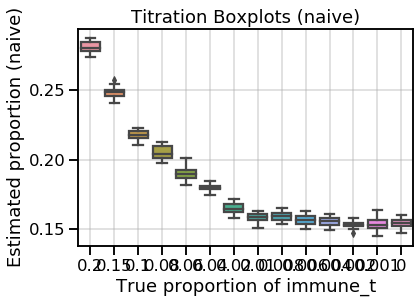

In [21]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_naive,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='naive'
                      )

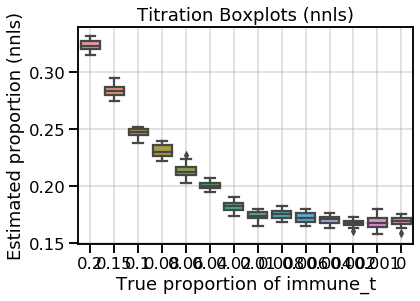

In [22]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='nnls'
                      )

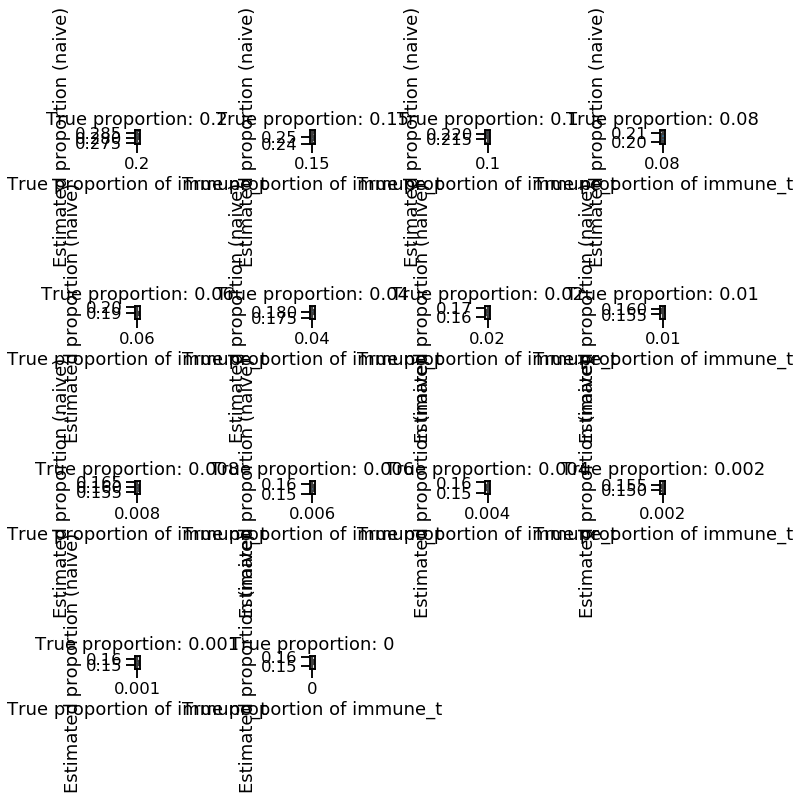

In [23]:

dcnv.boxplot_titration_zoom(list_of_deconvolution_dfs=deconvolution_naive,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='naive'
                      )

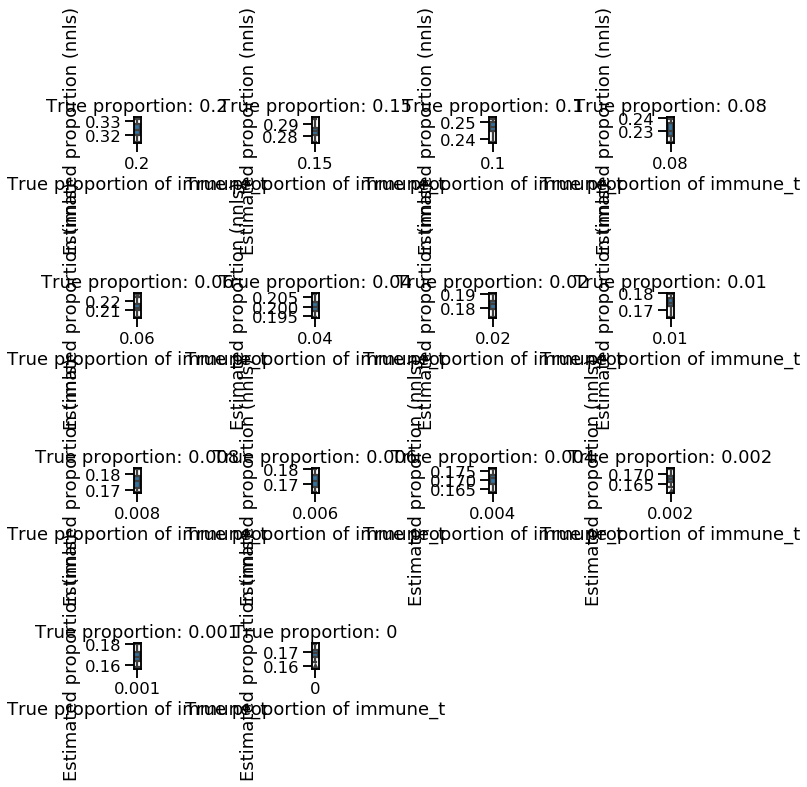

In [24]:

dcnv.boxplot_titration_zoom(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='nnls'
                      )